### Some good test queries in here, including
- Direct BQ SQL Queries
- Direct Queris of views I saved in BQ

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import datetime as dt
import matplotlib.dates as mdates
import pandas.io.formats.style

print("System: ", sys.version)
print("Numpy:", np.__version__)
print("Pandas:", pd.__version__)
import geopy.distance 
%matplotlib inline

In [27]:
%%capture
!pip install google-cloud-bigquery-storage

In [28]:
import warnings; warnings.simplefilter('ignore')

***
### START HERE:
#### I've divided the notebook into two sections. 
#### The first part, which follows immediately, is mostly work I'd not show a business consumer of this report. It contains the SQL queries and some manipulation and cleanup so that aren't long sections of code in the second section.It's the part where I show my work. 
#### The next section is the writeup proper. It's closer to what I'd present to a business user. 
***

***
##### A few notes on the data:
##### * The data in the trips_table is presented at UTC when it's in fact PST. (i.e. If it says 7AM UTC, it is in fact 7AM PST.)
##### * I excluded very short and extremely long trips from the dataset. In this case, it meant not including rides < 2 minutes 
##### or greater than 48 hours
##### * These trips represented a very small percentage of overall trips and it doesn't appear their inclusion would have meaningfully altered  statistics like the median trip length

***

***
#### This table aggregates total trips, scrubbed for outliers, per month
***

In [30]:
%%bigquery monthly_trips

SELECT
    DATE_SUB(DATE_ADD(DATE_TRUNC(DATE(end_date), MONTH),INTERVAL 1 MONTH), INTERVAL 1 DAY) AS Month,
    COUNT(trip_id) AS trips
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (duration_sec/60 > 2) AND (duration_sec/3600 < 48) 
GROUP BY 1 
ORDER BY 1

In [31]:
# Convert string dates to datetime & subset partial month Aug-13 out of dataset
monthly_trips['Month'] = pd.to_datetime(monthly_trips['Month'])
monthly_trips = monthly_trips[ monthly_trips['Month'] > "2013-08-31" ]
monthly_trips.set_index('Month', inplace = True)

In [32]:
monthly_trips['rolling_12'] = monthly_trips.trips.rolling(12, min_periods=6).mean()


***
#### This table aggregates total trip durations each month, scrubbed for outliers. 
#### The data here is in minutes, which I later restate into thousands of hours
***

In [33]:
%%bigquery monthly_duration

SELECT
  DATE_SUB(DATE_ADD(DATE_TRUNC(DATE(end_date), MONTH), INTERVAL 1 MONTH), INTERVAL 1 DAY) AS Month,
  SUM(duration_sec)/60 AS duration_minutes
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE (duration_sec/60 > 2) AND (duration_sec/3600 < 48)
GROUP BY 1 
ORDER BY 1

In [34]:
# Convert string dates to datetime & subset partial month Aug-13 out of dataset
monthly_duration['Month'] = pd.to_datetime(monthly_duration['Month'])
monthly_duration = monthly_duration[ monthly_duration['Month'] > "2013-08-31" ]
monthly_duration.set_index('Month', inplace = True)
monthly_duration['rolling_12'] = monthly_duration.duration_minutes.rolling(12, min_periods=6).mean()

***
#### The next table aggregates weekday trips per hour in order to determine what time of day 
#### has the most activity
***

In [35]:
%%bigquery trips_per_hour

SELECT
  EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(end_date), HOUR)) AS Hour,
  COUNT(DISTINCT trip_id) AS trips, 
FROM
  `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE
  (duration_sec/60 > 2) AND (duration_sec/3600 < 48) AND          
  EXTRACT(DAYOFWEEK FROM end_date) BETWEEN 2 AND 6 
GROUP BY
  1
ORDER BY
  1

In [36]:
trips_per_hour.set_index('Hour', inplace = True)

***
#### The next table aggregates commuter trips versus total trips in order to see how large a 
#### share commuter trips represent of the overall business
***

In [112]:
%%bigquery commute_vs_total_trips

  
SELECT 
    MONTH, COUNT(DISTINCT commuter_trips) as Commuter_Trips, COUNT(DISTINCT total_trips) as Total_Trips
FROM
(
  SELECT
    trip_id AS total_trips,        
    CASE WHEN 
      (duration_sec/60 > 2) AND (duration_sec/3600 < 48) AND  
      ((EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(end_date), HOUR)) BETWEEN 7 AND 9) OR
      (EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(start_date), HOUR)) BETWEEN 16 AND 18)) 

      AND EXTRACT(DAYOFWEEK FROM start_date) BETWEEN 2 AND 6 
      THEN trip_id
      ELSE NULL
      END
      AS commuter_trips,                          
    DATE_SUB(DATE_ADD(DATE_TRUNC(DATE(start_date), MONTH), INTERVAL 1 MONTH), INTERVAL 1 DAY) AS Month
      
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
) 
GROUP BY 1
ORDER BY 1;

***
#### The next table allows us to look at the morning versus evening split in the number of commuter trips
***

In [38]:

%%bigquery commute_am_vs_pm


SELECT 
    COUNT(DISTINCT commuter_trips_am), COUNT(DISTINCT commuter_trips_pm), COUNT(DISTINCT commuter_trips_tot)
FROM
(
  SELECT
    trip_id AS total_trips,        
    
    CASE WHEN 
        (duration_sec/60 > 2) AND (duration_sec/3600 < 48) AND  
        (EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(end_date), HOUR)) BETWEEN 7 AND 9) AND
        EXTRACT(DAYOFWEEK FROM end_date) BETWEEN 2 AND 6 
      THEN trip_id
        ELSE NULL
      END
      AS commuter_trips_am,                          
    
    CASE WHEN 
        (duration_sec/60 > 2) AND (duration_sec/3600 < 48) AND  
        (EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(start_date), HOUR)) BETWEEN 16 AND 18)
        AND EXTRACT(DAYOFWEEK FROM start_date) BETWEEN 2 AND 6 
      THEN trip_id
        ELSE NULL
      END
      AS commuter_trips_pm,       

    CASE WHEN 
        (duration_sec/60 > 2) AND (duration_sec/3600 < 48) AND          
        
        ((EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(end_date), HOUR)) BETWEEN 7 AND 9)  OR
        (EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(start_date), HOUR)) BETWEEN 16 AND 18))  
              
        AND EXTRACT(DAYOFWEEK FROM start_date) BETWEEN 2 AND 6 
      THEN trip_id
        ELSE NULL
      END
      AS commuter_trips_tot,      

    DATE_SUB(DATE_ADD(DATE_TRUNC(DATE(start_date), MONTH), INTERVAL 1 MONTH), INTERVAL 1 DAY) AS Month

    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
) 


***
#### The following table produces counts of trips organized by station pairs, where the ordering of the pairs is collapsed
#### i.e. A trip from A->B and a trip from B->A are all considered the same trip for counting purposes
#### Additionally, the latitude/logitude for each station is included, as are the number of trips and the average trip
#### length between each pair of stations
***

In [39]:
%%bigquery top10_commutes

WITH trip_table AS(
  SELECT
    *,
    CASE WHEN start_station_name < end_station_name THEN start_station_name ELSE end_station_name END AS A,   
    CASE WHEN start_station_name < end_station_name THEN end_station_name ELSE start_station_name END AS B
  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
), 

stations AS(
  SELECT
    name, longitude, latitude
  FROM  
    `bigquery-public-data.san_francisco.bikeshare_stations` 
)  

SELECT
  trip_table.A AS Station_1, trip_table.B AS Station_2, 
  A_station.longitude AS Station_1_longitude,
  A_station.latitude AS Station_1_latitude,
  B_station.longitude AS Station_2_longitude,
  B_station.latitude AS Station_2_latitude,
  COUNT (DISTINCT trip_id) Trip_Count,
  SUM(duration_sec/60)/COUNT(DISTINCT trip_id) AS Avg_Trip_In_Minutes

FROM trip_table    
  LEFT JOIN stations A_station
  ON  trip_table.A = A_station.name 
  LEFT JOIN stations B_station
  ON trip_table.B = B_station.name

WHERE 
  (duration_sec/60 > 2) AND (duration_sec/3600 < 48) AND

  ((EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(end_date), HOUR)) BETWEEN 7 AND 9) OR         
  (EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(start_date), HOUR)) BETWEEN 16 AND 18))

  AND (EXTRACT(DAYOFWEEK FROM start_date) BETWEEN 2 AND 6) 
   
 
GROUP BY 1, 2, 3, 4, 5, 6
ORDER BY 7 DESC
LIMIT 10


In [40]:
# Add temp column to hold distance between stations and then use geopy to populate
t10 = top10_commutes
t10["Distance"] =np.NaN
for index, row in t10.iterrows():  
    t10.Distance[index] = geopy.distance.geodesic((t10.Station_1_latitude[index],t10.Station_1_longitude[index]), 
                                                  (t10.Station_2_latitude[index],t10.Station_2_longitude[index])).miles
    
    

In [41]:
t10

,Station_1,Station_2,Station_1_longitude,Station_1_latitude,Station_2_longitude,Station_2_latitude,Trip_Count,Avg_Trip_In_Minutes,Distance
0,2nd at Townsend,Harry Bridges Plaza (Ferry Building),-122.390288,37.780526,-122.394203,37.795392,10228,9.109805,1.047424
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,-122.395470,37.776600,-122.402717,37.771058,9228,4.458162,0.550893
2,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),-122.391034,37.791464,-122.395260,37.776617,8482,10.743612,1.049762
3,Harry Bridges Plaza (Ferry Building),San Francisco Caltrain (Townsend at 4th),-122.394203,37.795392,-122.395260,37.776617,8327,12.420952,1.296157
4,Embarcadero at Sansome,Steuart at Market,-122.403234,37.804770,-122.394434,37.794139,8252,7.658261,0.877208
5,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),-122.395260,37.776617,-122.394643,37.789756,8139,11.060634,0.906793
6,San Francisco Caltrain (Townsend at 4th),Steuart at Market,-122.395260,37.776617,-122.394434,37.794139,8020,12.005981,1.209294
7,2nd at Townsend,Steuart at Market,-122.390288,37.780526,-122.394434,37.794139,7866,8.991626,0.965890
8,2nd at South Park,Market at Sansome,-122.392738,37.782259,-122.400811,37.789625,7086,7.416100,0.673299
9,Market at 10th,San Francisco Caltrain 2 (330 Townsend),-122.417385,37.776619,-122.395470,37.776600,6896,11.176257,1.199665


***
RETRIEVE THE PERCENTILES OF RIDE LENGTHS

***

In [117]:
%%bigquery commute_ride_percentiles

SELECT approx_quantiles(duration_sec/60, 100) AS percentiles
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE 
  (duration_sec/60 > 2) AND (duration_sec/3600 < 12) AND
  ((EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(end_date), HOUR)) BETWEEN 7 AND 9) OR         
  (EXTRACT(HOUR FROM DATETIME_TRUNC(DATETIME(start_date), HOUR)) BETWEEN 16 AND 18))
  AND (EXTRACT(DAYOFWEEK FROM start_date) BETWEEN 2 AND 6) 


In [118]:
commute_ride_percentiles = pd.DataFrame(commute_ride_percentiles['percentiles'][0])
commute_ride_percentiles.rename(columns={0: 'Commuter_Trips(min)'}, inplace=True)
commute_ride_percentiles.index.names = ["Percentile"]

In [119]:
%%bigquery total_ride_percentiles

SELECT approx_quantiles(duration_sec/60, 100) AS percentiles
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE 
  (duration_sec/60 > 2) AND (duration_sec/3600 < 48)
 

In [120]:
total_ride_percentiles = pd.DataFrame(total_ride_percentiles['percentiles'][0])
total_ride_percentiles.rename(columns={0: 'All_Trips(min)'}, inplace=True)
total_ride_percentiles.index.names = ["Percentile"]

In [121]:
percentiles_df = pd.DataFrame(columns=['Commuter_Trips(min)', 'All_Trips(min)'], index=[10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100])
percentiles_df.index.names = ["Percentile"]

In [122]:
for idx in percentiles_df.index:
    percentiles_df['Commuter_Trips(min)'][idx] = commute_ride_percentiles['Commuter_Trips(min)'][idx] 
    percentiles_df['All_Trips(min)'][idx] = total_ride_percentiles['All_Trips(min)'][idx] 

In [123]:
percentiles_df

,Commuter_Trips(min),All_Trips(min)
Percentile,,
10,4.15,4.08333
20,5.33333,5.28333
30,6.38333,6.4
40,7.41667,7.51667
50,8.45,8.66667
60,9.56667,9.96667
70,10.8667,11.5333
80,12.5167,13.75
90,15.1,18.5833


***
Retrieve the distance of stations from the center of downtown San Francisco

***

In [134]:
%%bigquery station_distance

WITH params AS (
  SELECT ST_GeogPoint(-122.39903, 37.78545) AS center,
         --50 AS maxn_stations,
         --50 AS maxdist_km
),
distance_from_center AS (
  SELECT
    name, 
    ST_Distance(ST_GeogPoint(longitude, latitude), params.center)/1609.34 AS dist_miles,
    landmark
  FROM
    `bigquery-public-data.san_francisco.bikeshare_stations`,
    params
  WHERE 
    landmark = 'San Francisco'
)

SELECT name as Station_Name, dist_miles as Distance_From_Central_Downtown
FROM
distance_from_center
ORDER BY 2 DESC
LIMIT 10


In [135]:
station_distance

,Station_Name,Distance_From_Central_Downtown
0,Embarcadero at Sansome,1.354478
1,South Van Ness at Market,1.312963
2,Market at 10th,1.173453
3,San Francisco City Hall,1.149179
4,Golden Gate at Polk,1.106045
5,Townsend at 7th,1.014575
6,Embarcadero at Vallejo,1.002444
7,Grant Avenue at Columbus Avenue,0.939362
8,Broadway St at Battery St,0.910019
9,Davis at Jackson,0.818021


### Writeup Begins

***
  
### Project goal: Increase ridership
  

##### To that end, we'll start with two measures of ridership. The first measure is just the number of trips per month.

##### As you can see below, the 12-month moving average, which attempts to adjust for  
##### significant seasonal variation, declined approximately 11% between Aug-2015 and Aug-2016.  
##### Additionally, there's little growth to speak of over the entire time frame.

***

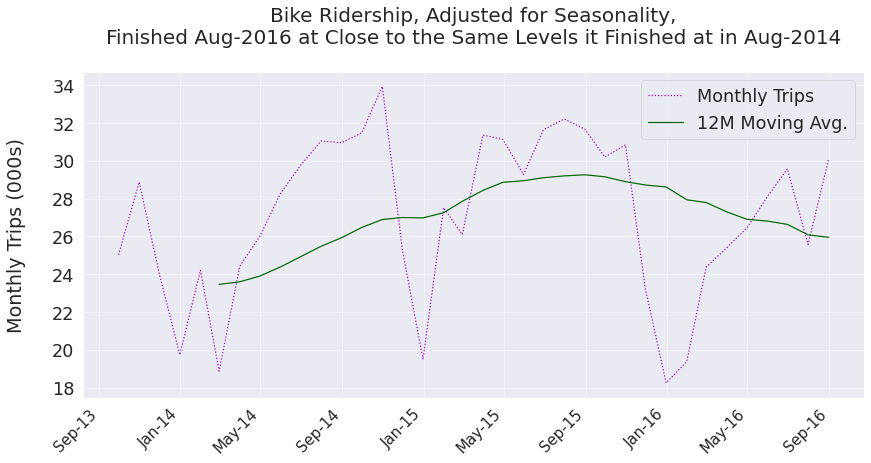

In [44]:

sns.set_context("paper", font_scale = 2, rc={"grid.linewidth": 0.5})
sns.set_style("darkgrid")
fig1, ax1 = plt.subplots(figsize = (14,6))

sns.lineplot(data = monthly_trips.trips/1000, ax = ax1,  color = 'darkviolet', dashes=[':'], label = "Monthly Trips" , legend = False )
sns.lineplot(data = monthly_trips.rolling_12/1000, ax = ax1, color = 'darkgreen',  label = "12M Moving Avg.", legend = False )

ax1.lines[0].set_linestyle(":")

leg = ax1.legend()
ax1.set_ylabel('Monthly Trips (000s)\n')
ax1.set_title("Bike Ridership, Adjusted for Seasonality,\nFinished Aug-2016 at Close to the Same Levels it Finished at in Aug-2014\n", size = 20)

fmt = '%b-%y' # Format you want the ticks, e.g. '40%'
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', size = 15)    
ax1.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
leg = ax1.legend()


***
  
##### The second measure is the total time spent on bikes. This allows us to go a little beyond the number of trips and account for a time-based measure.

***

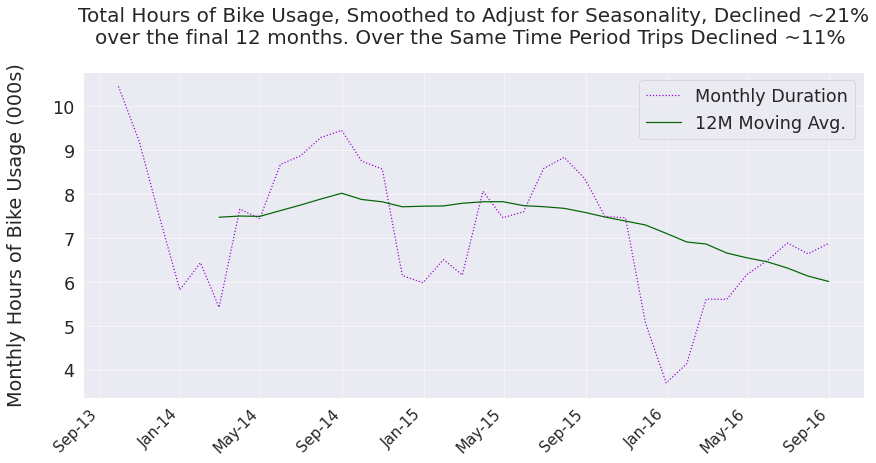

In [57]:

sns.set_context("paper", font_scale = 2, rc={"grid.linewidth": 0.5})
sns.set_style("darkgrid")
fig1, ax1 = plt.subplots(figsize = (14,6))

sns.lineplot(data = monthly_duration.duration_minutes/60000, ax = ax1,  color = 'darkviolet', dashes=[':'], label = "Monthly Duration" , legend = False )
sns.lineplot(data = monthly_duration.rolling_12/60000, ax = ax1, color = 'darkgreen',  label = "12M Moving Avg.", legend = False )

ax1.lines[0].set_linestyle(":")

leg = ax1.legend()
ax1.set_ylabel('Monthly Hours of Bike Usage (000s)\n')
ax1.set_title("Total Hours of Bike Usage, Smoothed to Adjust for Seasonality, Declined ~21%\nover the final 12 months. Over the Same Time Period Trips Declined ~11% \n", size = 20)

fmt = '%b-%y' # Format you want the ticks, e.g. '40%'
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', size = 15)    
ax1.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
leg = ax1.legend()


***
##### As shown above, usage, as measured by hours spent on bikes, dropped 21% between Aug-2015 and Aug-2016. 
##### This implies that average trip length declined over this period 
##### *(Note that to account for wide seasonal variation, we applied a 12 month moving average to make the trend clearer.)*
***

***
  
##### Next,to understand commute trips better, we'd like to see how hourly trips are distributed over weekdays so we can DEFINE what commute hours are.
***


Text(0.5, 0, '\nTime of Day')

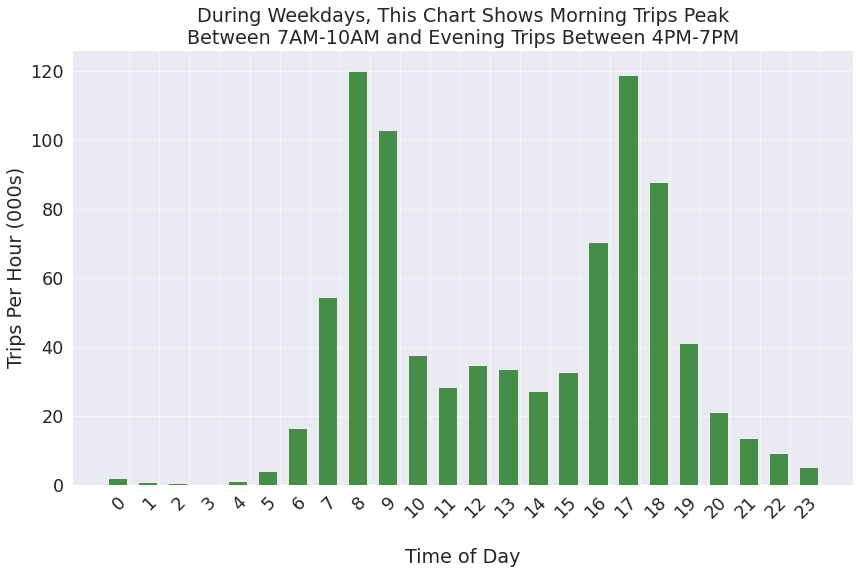

In [24]:

fig, ax = plt.subplots(figsize = (14,8))

# https://www.geeksforgeeks.org/bar-plot-in-matplotlib/

width = 0.8  # the width of the bars

# height of bars
trips = trips_per_hour.trips

# position of bars
br1 = np.arange(len(trips_per_hour.index))

# colors: https://www.colorhexa.com/002fa7
# plot '#1e5dff'


ax.bar(br1, trips/1000, color = [0,.4,0,.7], width = 0.8*width, label="" )


ax.set_xticks([r + width/2 for r in range(len(trips_per_hour))]) 
ax.set_xticklabels(trips_per_hour.index) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right') 


ax.set_title("Trips Each Hour During Weekdays")

ax.set_title("During Weekdays, This Chart Shows Morning Trips Peak\nBetween 7AM-10AM and Evening Trips Between 4PM-7PM")

ax.set_ylabel("Trips Per Hour (000s)")
ax.set_xlabel("\nTime of Day")


***
##### As the above chart shows, 7AM-10AM & 4PM-7PM between Monday and Friday are when trips peak.
##### We'll use those time periods as part of our definition of commute hours
***

### <span style='color:green'> **Commuter Trip Definition**

##### We defined a commuter trip as:
##### * Rides that occurred between Monday & Friday AND
##### * EITHER
##### * A ride that had an end_time between 7AM and 9:59AM (We also subclassified these as morning commutes) OR
##### * A ride that had an start_time between 4PM and 6:59PM (We also subclassified these as evening commutes)
##### * AND
##### * Rides that were betwween 2 minutes and 48 hours long. We viewed rides outside this span as outliers, although
##### * including them wouldn't have meaningfully distorted our analysis

***
##### It's assumed that commuter trips are important, but we should measure what percentage commuter trips represent of the all trips to see exactly how important they are.
***

In [113]:
# Convert string dates to datetime & subset partial month Aug-13 out of dataset
commute_vs_total_trips['MONTH'] = pd.to_datetime(commute_vs_total_trips['MONTH'])
commute_vs_total_trips = commute_vs_total_trips[ commute_vs_total_trips['MONTH'] > "2013-08-31" ]
commute_vs_total_trips.set_index('MONTH', inplace = True)

# Give the Columns accurate names
#commute_vs_total_trips.rename(columns={"f0_": "Commuter_Trips", "f1_": "Total_Trips"}, inplace=True)



In [114]:
# Create a custom date range columns for 12 month periods ending in August

date_list = [('2013-09-30', '2014-08-31'), ('2014-09-30', '2015-08-31'), ('2015-09-30', '2016-08-31')]
commute_vs_total_trips.insert (0, 'Year_Ending', np.NaN)

for dates in date_list:
    is_between = (commute_vs_total_trips.index >= dates[0]) & (commute_vs_total_trips.index <= dates[1]) 
    commute_vs_total_trips.Year_Ending[is_between] = dates[1]

In [115]:
# Convert dataframe into a pivot table so we can get column totals

pivot1 = pd.pivot_table(commute_vs_total_trips, index = 'Year_Ending', values=['Commuter_Trips', 'Total_Trips'], columns = [], aggfunc = np.sum,  margins = True, margins_name='Total')
df2 = pd.DataFrame(pivot1)

# Convert pivot table back into data frame so we can easily add a percent of total column
df2['Percent_of_Total'] = df2.Commuter_Trips/df2.Total_Trips
df2 = df2.style.format({"Commuter_Trips" : "{:,d}", "Total_Trips" : "{:,d}", "Percent_of_Total" : "{:.0%}"       })
df2

,Commuter_Trips,Total_Trips,Percent_of_Total
Year_Ending,,,
2014-08-31,"156,900","313,705",50%
2015-08-31,"202,710","354,152",57%
2016-08-31,"191,167","313,689",61%
Total,"550,777","981,546",56%


***
We can see several things from the table above:
##### - Commuter trips are a very high percentage of total trips
##### - Commute hours represent only ~18% of weekly hours, but 61% of trips in the most recent year
##### - Commute hours as a percentage of total hours increased every year
##### - There's almost no growth between the first year and the final year of total trips. That's not good. 

**Conclusion: Commuter trips are, in fact, extremely important to the business**

***

***
The next thing we'll look at is the breakout of the number of commute trips in the morning and the evening
***

In [72]:
# Give the Columns accurate names
commute_am_vs_pm.rename(columns={"f0_": "Morning Commute Trips", "f1_": "Evening Commute Trips", "f2_": "Total Commute Trips"},
                        inplace=True)


In [73]:

index_ = ["Total"]
commute_am_vs_pm.index = index_ 
commute_am_vs_pm = commute_am_vs_pm.style.format({"Morning Commute Trips" : "{:,d}", "Evening Commute Trips" : "{:,d}", 
                                                  "Total Commute Trips" : "{:,d}"})
commute_am_vs_pm

,Morning Commute Trips,Evening Commute Trips,Total Commute Trips
Total,"277,604","273,816","551,255"


***

##### A quick look shows a very even split between the number of morning and the number of evening commute trips

***

***
##### The next thing we will look at are the 10 frequent commuter routes
##### *Note: These stations pairs are unordered.*
##### *e.g. Both trips from "2nd at Townsend" to "Steuart at Market" and "Steuart at Market" to "2nd at Townsend"*
##### *are treated as a "2nd at Townsend" to "Steuart at Market"*
***


### <span style='color:green'> **Ten Most Frequent Commuter Trips**

In [75]:

#temp_df.style.clear()
temp_df = t10[['Station_1', 'Station_2', 'Trip_Count', 'Avg_Trip_In_Minutes', 'Distance' ]]
#temp_df = temp_df.style.format({"Trips" : "{:,d}"})
temp_df.index = np.arange(1, len(temp_df)+1)
temp_df.index = temp_df.index.rename("Rank") 
temp_df=temp_df.rename(columns={"Distance": "Distance(miles)"})
temp_df=temp_df.style.format({"Trip_Count" : "{:,d}","Avg_Trip_In_Minutes" : "{:,.1f}", "Distance(miles)" : "{:.1f}"      })
temp_df

,Station_1,Station_2,Trip_Count,Avg_Trip_In_Minutes,Distance(miles)
Rank,,,,,
1,2nd at Townsend,Harry Bridges Plaza (Ferry Building),"10,228",9.1,1.0
2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,"9,228",4.5,0.6
3,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),"8,482",10.7,1.0
4,Harry Bridges Plaza (Ferry Building),San Francisco Caltrain (Townsend at 4th),"8,327",12.4,1.3
5,Embarcadero at Sansome,Steuart at Market,"8,252",7.7,0.9
6,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),"8,139",11.1,0.9
7,San Francisco Caltrain (Townsend at 4th),Steuart at Market,"8,020",12.0,1.2
8,2nd at Townsend,Steuart at Market,"7,866",9.0,1.0
9,2nd at South Park,Market at Sansome,"7,086",7.4,0.7


***
#### <span style='color:green'> *Observations*
##### * Anyone familiar with San Francisco will set that all of these stations are either downtown or in the SOMA neighborhood 
##### * The majority of San Franciscans do not live in either of these neighborhoods
##### * Additionally, all of these stations are either transit hubs for other forms of mass transit or very close to one (e.g. MUNI for
##### bus and light rail within the city, Caltrain and BART for commuters from the South and East Bay as well as ferry service from 
##### the North and East Bay. This likely explains why the same stations appear repeatedly on the list above. 
##### * The distances between these stations are between 0.6 and 1.3 miles, with average trip lengths of between 4.5 and 12.4 minutes.
##### * For commuters, the median trip is ~8.5 minutes while for ALL trips it's ~8.7 minutes. Given that we saw above that commuters
##### represented more than half of all trips, this isn't surprising. 
#### <span style='color:green'> *Conclusions*:
##### * Given that most San Franciscans don't live near these stations and that all of the stations are near mass transit hubs, it 
##### seems likely that the most common commuter use case is to use bikes to go the "final mile" between some other form of mass
##### transit and their home or office. 
##### <span style='color:green'>* While this isn't a definitive picture of ALL commuters, if further analysis shows that this type of commute is representative
##### <span style='color:green'> of the majority of commuters, than that user profile should inform the marketing to those customers. 
***

***

##### Given how short the most popular commuter trips are, we thought it would be advisable to see how long
##### trips were, by looking at ride length percentiles for both commuter trips and trips as a whole

***

In [130]:
percentiles_df.style.format({"Commuter_Trips(min)" : "{0:.1f}" ,"All_Trips(min)" : "{0:.1f}" })


,Commuter_Trips(min),All_Trips(min)
Percentile,,
10,4.2,4.1
20,5.3,5.3
30,6.4,6.4
40,7.4,7.5
50,8.4,8.7
60,9.6,10.0
70,10.9,11.5
80,12.5,13.8
90,15.1,18.6


***

##### - The median trip (50th percentile), for both groups is ~8.5 minutes
##### - Even at the 90th percentile, ride lengths are between 15 and 19 minutes
##### **Conclusion: For overwhelming majority of users, the primary use cases are very short rides**

***

***

##### To get a sense of how far stations are located from downtown, we chose a central point downtown
##### and measured the distance of stations from that point. The results surprised us. 
***

In [137]:
station_distance.style.format({"Distance_From_Central_Downtown" : "{0:.2f}"})

,Station_Name,Distance_From_Central_Downtown
0,Embarcadero at Sansome,1.35
1,South Van Ness at Market,1.31
2,Market at 10th,1.17
3,San Francisco City Hall,1.15
4,Golden Gate at Polk,1.11
5,Townsend at 7th,1.01
6,Embarcadero at Vallejo,1.00
7,Grant Avenue at Columbus Avenue,0.94
8,Broadway St at Battery St,0.91
9,Davis at Jackson,0.82


***

##### These stations are sorted in reverse order of their distance from downtown. 
##### That means EVERY SINGLE OTHER STATION is closer to that point
##### The conclusion is that the stations cover a tiny fraction of San Francisco's ~50 square miles
##### EVERY SINGLE STATION IS WITHIN 1.5 MILES OF DOWNTOWN. There's a huge opportunity to expand the station footprint. 
***

***
## <span style='color:green'> *Recommendations*

##### There's been very little overall trip growth over the 3 years of data  
##### As we said above, the number and distribution of station should be expanded because the existing stations cover a tiny fraction of San Francisco. That's a huge opportunity. 
##### Commuter growth has been a little stronger than non-commuter growth, but it appears that this is at least partly a function of the fact that the service was built for commuters by placing most stations downtown.  
##### Growing the business will require separate strategies for commuters and non-commuters
##### To growth the existing transit-point-to-transit-point business downtown, several marketing tactics should be employed:  
    
##### * Make sure potential customers are aware of the bike option through advertisting  
    
##### * Attempt to partner with employers to make an annual membership either a free or subsidized perk of employement
    
##### * Most trips are commuter trips and those trips seem to be primarily concentrated downtown  
    
##### * Be strategic about sending alerts and reminders: When the weather is pleasant or when bus and car traffic will grind to a halt due to a ball game, a bike trip is a more compelling alternative. 
    
##### Another group that should be targeted and that currently is not are commuters within the city:
    
##### * To put it bluntly, bike stations are not in the neighborhoods where most of the people in the city live. Start putting stations in those neighborhoods. Some of that will result in additional commuter trips and additional ridership. 
    
##### * The commute trips from those neighborhoods will be longer than most existing trips. They will be more physically taxing. More widespread rollout of ebikes may help overcome that as a challenge. 
    
***

***
#### <span style='color:green'> *5 Most Popular Commute Trips*
##### Although the top 10 commuter trips are presented above, the instructions said to present them in Markdown. So we're repeating that here: 
***

<div align="left"> </align>

In [ ]:
%%html
<style>
table {float:left}
</style>


| Rank |                               Station_1 |                                Station_2 | Trip_Count |
|-----:|----------------------------------------:|-----------------------------------------:|-----------:|
|    1 |                         2nd at Townsend |     Harry Bridges Plaza (Ferry Building) |     10,228 |
|    2 | San Francisco Caltrain 2 (330 Townsend) |                          Townsend at 7th |      9,228 |
|    3 |                   Embarcadero at Folsom | San Francisco Caltrain (Townsend at 4th) |      8,482 |
|    4 |    Harry Bridges Plaza (Ferry Building) | San Francisco Caltrain (Townsend at 4th) |      8,327 |
|    5 |                  Embarcadero at Sansome |                        Steuart at Market |      8,252 |